In [54]:
import rasterio as rio
import os
import json
import pandas as pd
from PIL import ImageColor
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, Input, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [55]:
# Location of data
lc_dir = 'data/lc.json'
lc_image_dir = 'https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/LC_Image_v1.tif'
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [56]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values                      label  values_normalize
0   #006400    2001     Primary dryland forest                 1
1   #228B22    2002   Secondary dryland forest                 2
2   #4B0082    2004    Primary mangrove forest                 3
3   #808000    2005       Primary swamp forest                 4
4   #32CD32    2006          Plantation forest                 5
5   #90EE90    2007                  Dry shrub                 6
6   #FF4500    2010                Estate crop                 7
7   #F08080    2012                 Settlement                 8
8   #D2B48C    2014                Bare ground                 9
9   #ADFF2F    3000        Savanna and grasses                10
10  #87CEFA    5001                 Open water                11
11  #6A5ACD   20041  Secondary mangrove forest                12
12  #6B8E23   20051     Secondary swamp forest                13
13  #66CDAA   20071                  Wet shrub                14
14  #FFD700   20091       Pure dry agriculture                15
15  #FFA500   20092      Mixed dry agriculture                16
16  #008080   20093                Paddy field                17
17  #E6E6FA   20094      Fish pond/aquaculture                18
18  #B22222   20121            Port or harbour                19
19  #C71585   20122       Transmigration areas                20
20  #A0522D   20141                     Mining                21
21  #7FFFD4   50011                      Swamp                22

In [57]:
# load image sample
lc_values = os.listdir('data/images')
lc_values = list(map(lambda x: int(x.split('_')[0]), lc_values))
lc_values = np.unique(lc_values)
lc_values.sort()
lc_values

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 20, 22])

In [58]:
# Function to augment and add more sample
def augment(array, list):
	flip = np.flip(array, 1)
	for arr in [array, flip]:
		for rot in [1, 2, 3]:
			list.append(np.rot90(arr, rot))

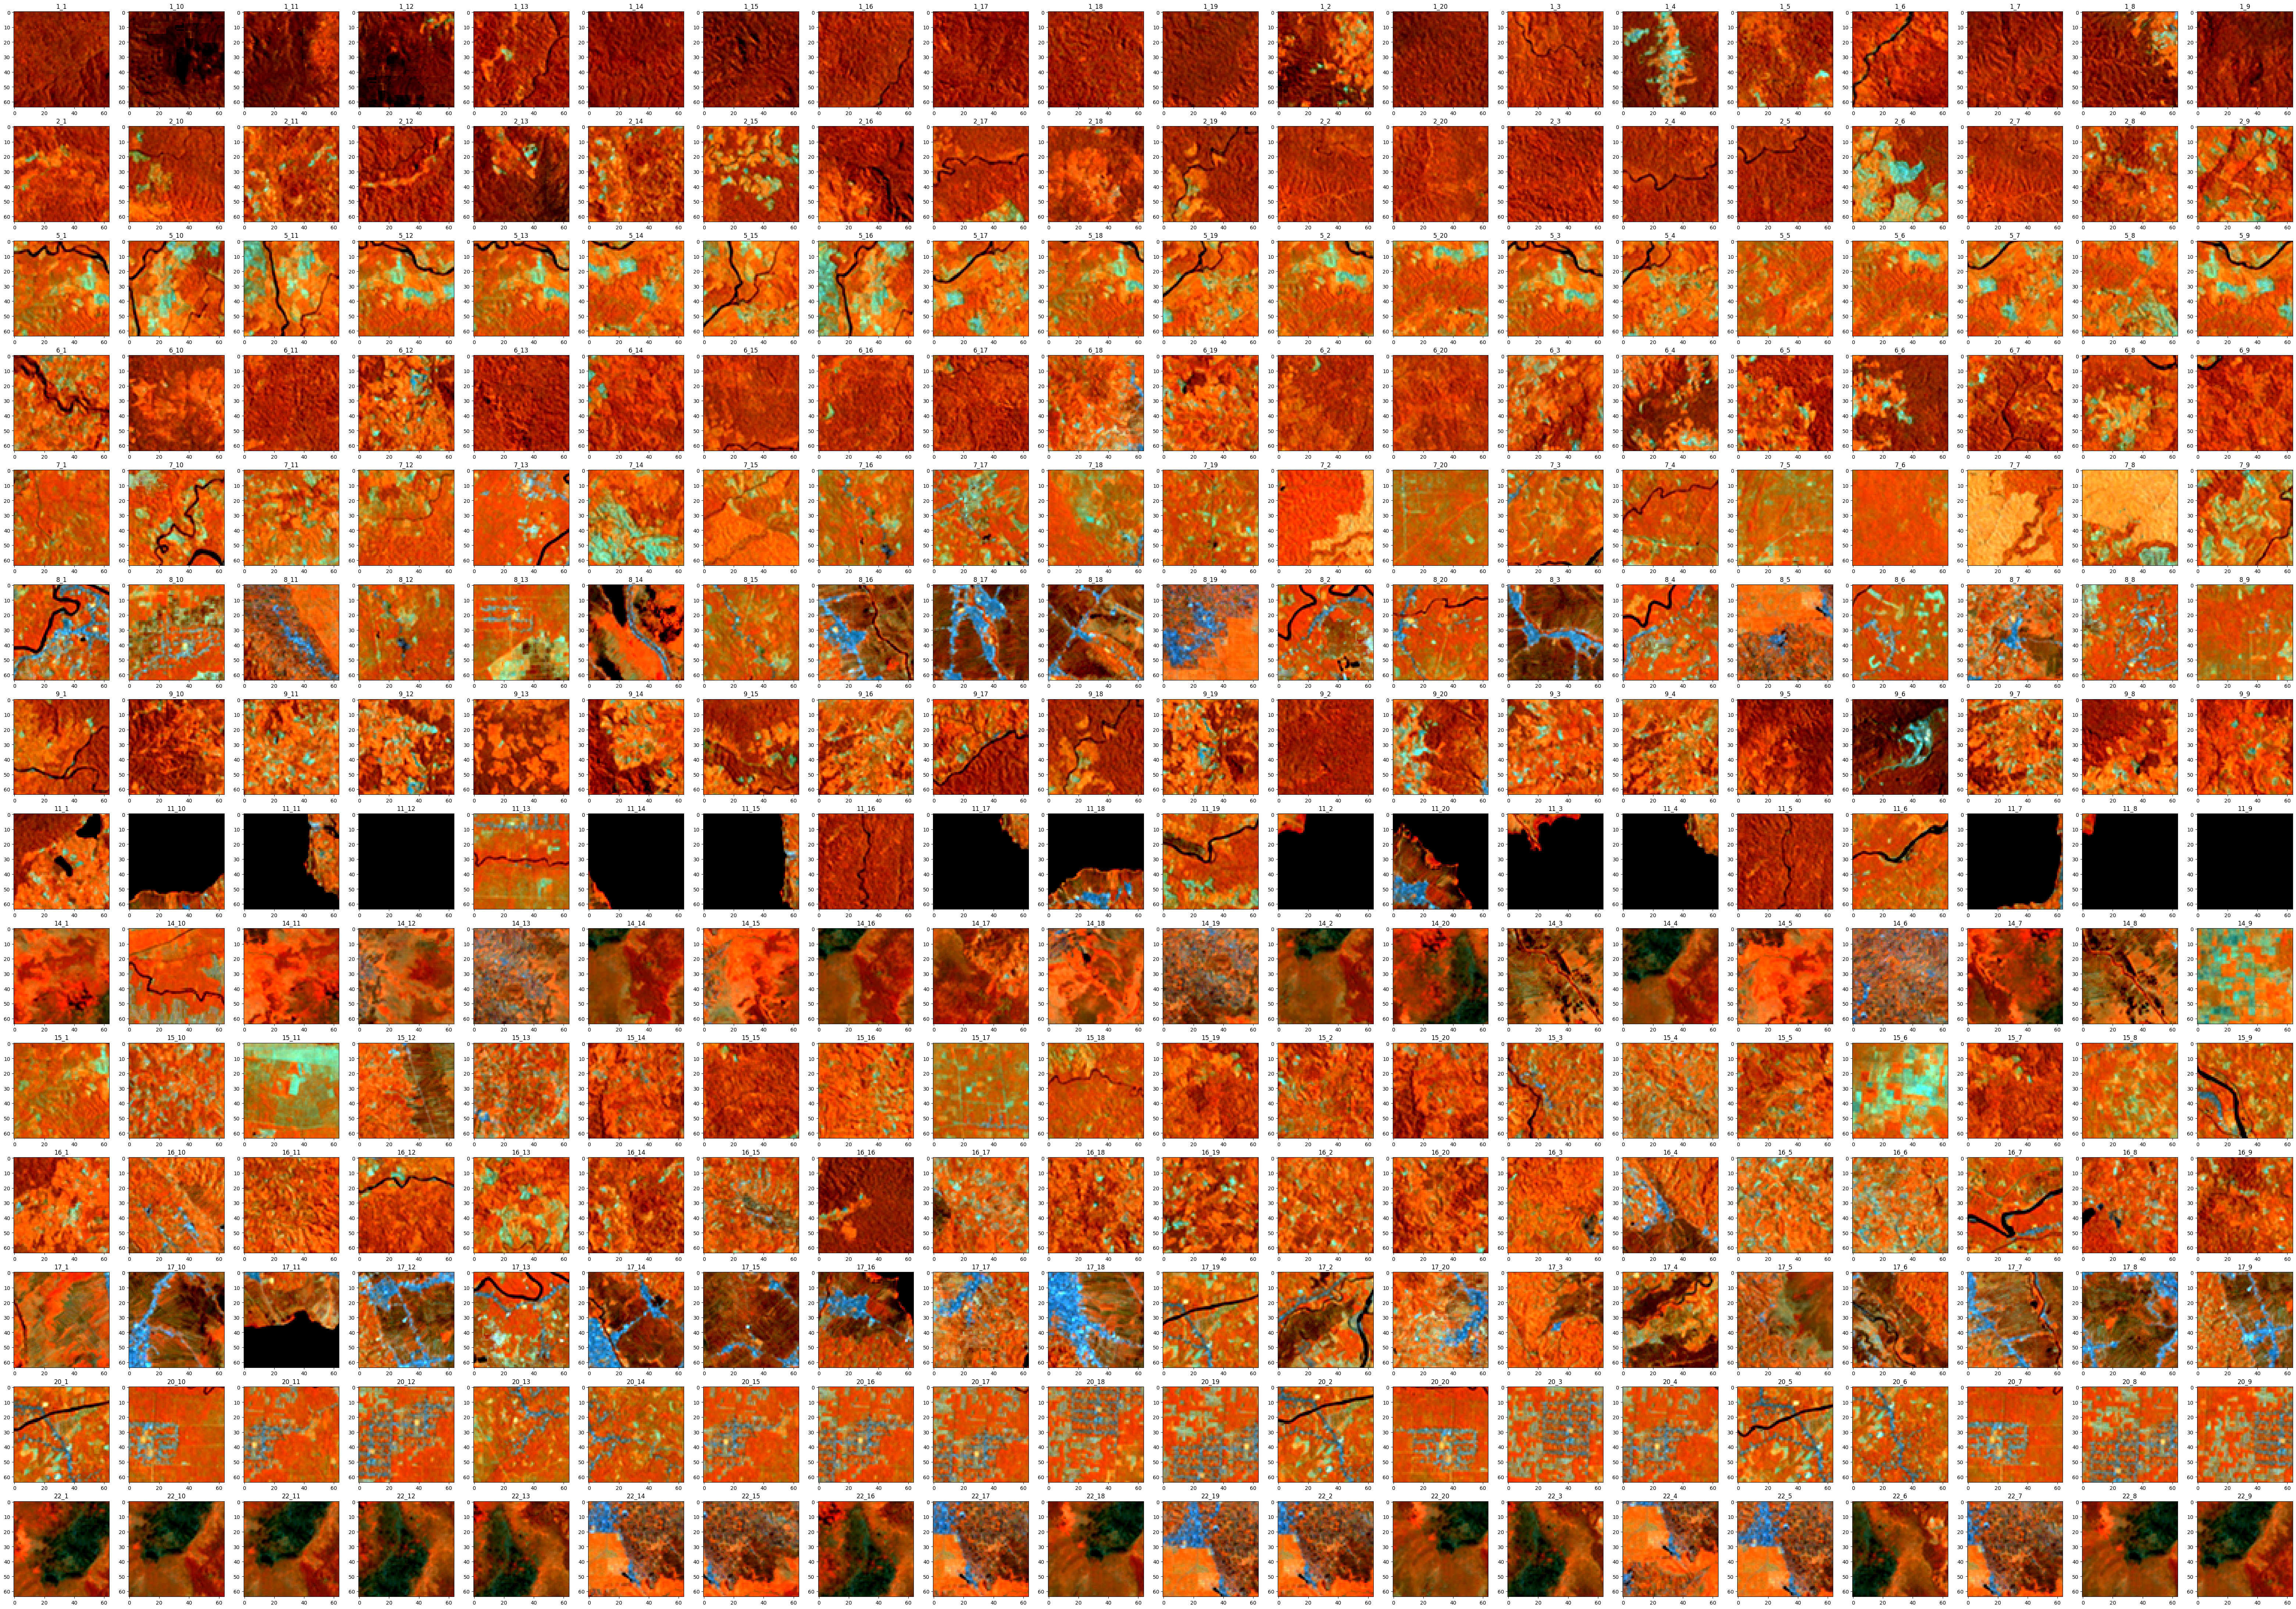

In [61]:
# Define image per land cover
image_per_lc = 20
index_train = int(8 / 10 * image_per_lc)

plt.figure(figsize=(4 * image_per_lc, 4 * len(lc_values)))

# List of images
images_train = []
images_test = []

# Load image first
for x in range(0, len(lc_values)):
	lc = lc_values[x]
	images_list = os.listdir('data/images')
	images_list = list(filter(lambda x: int(x.split('_')[0]) == lc, images_list))

	for y in range(0, len(images_list)):
		dir = images_list[y]
		name = dir.split('.')[0]
		image_dir = f'data/images/{dir}'
		source = rio.open(image_dir)

		# Make it into a image shape to plot
		image = np.transpose(source.read(), (1, 2, 0))

		# Augment then add to the list
		augment(image, images_train if (y < index_train) else images_test)

		# Plot the image
		plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
		plt.imshow(image)
		plt.title(f'{name}')

		source.close()

# Turn in into numpy array stacks
images_train = np.stack(images_train)
images_test = np.stack(images_test)

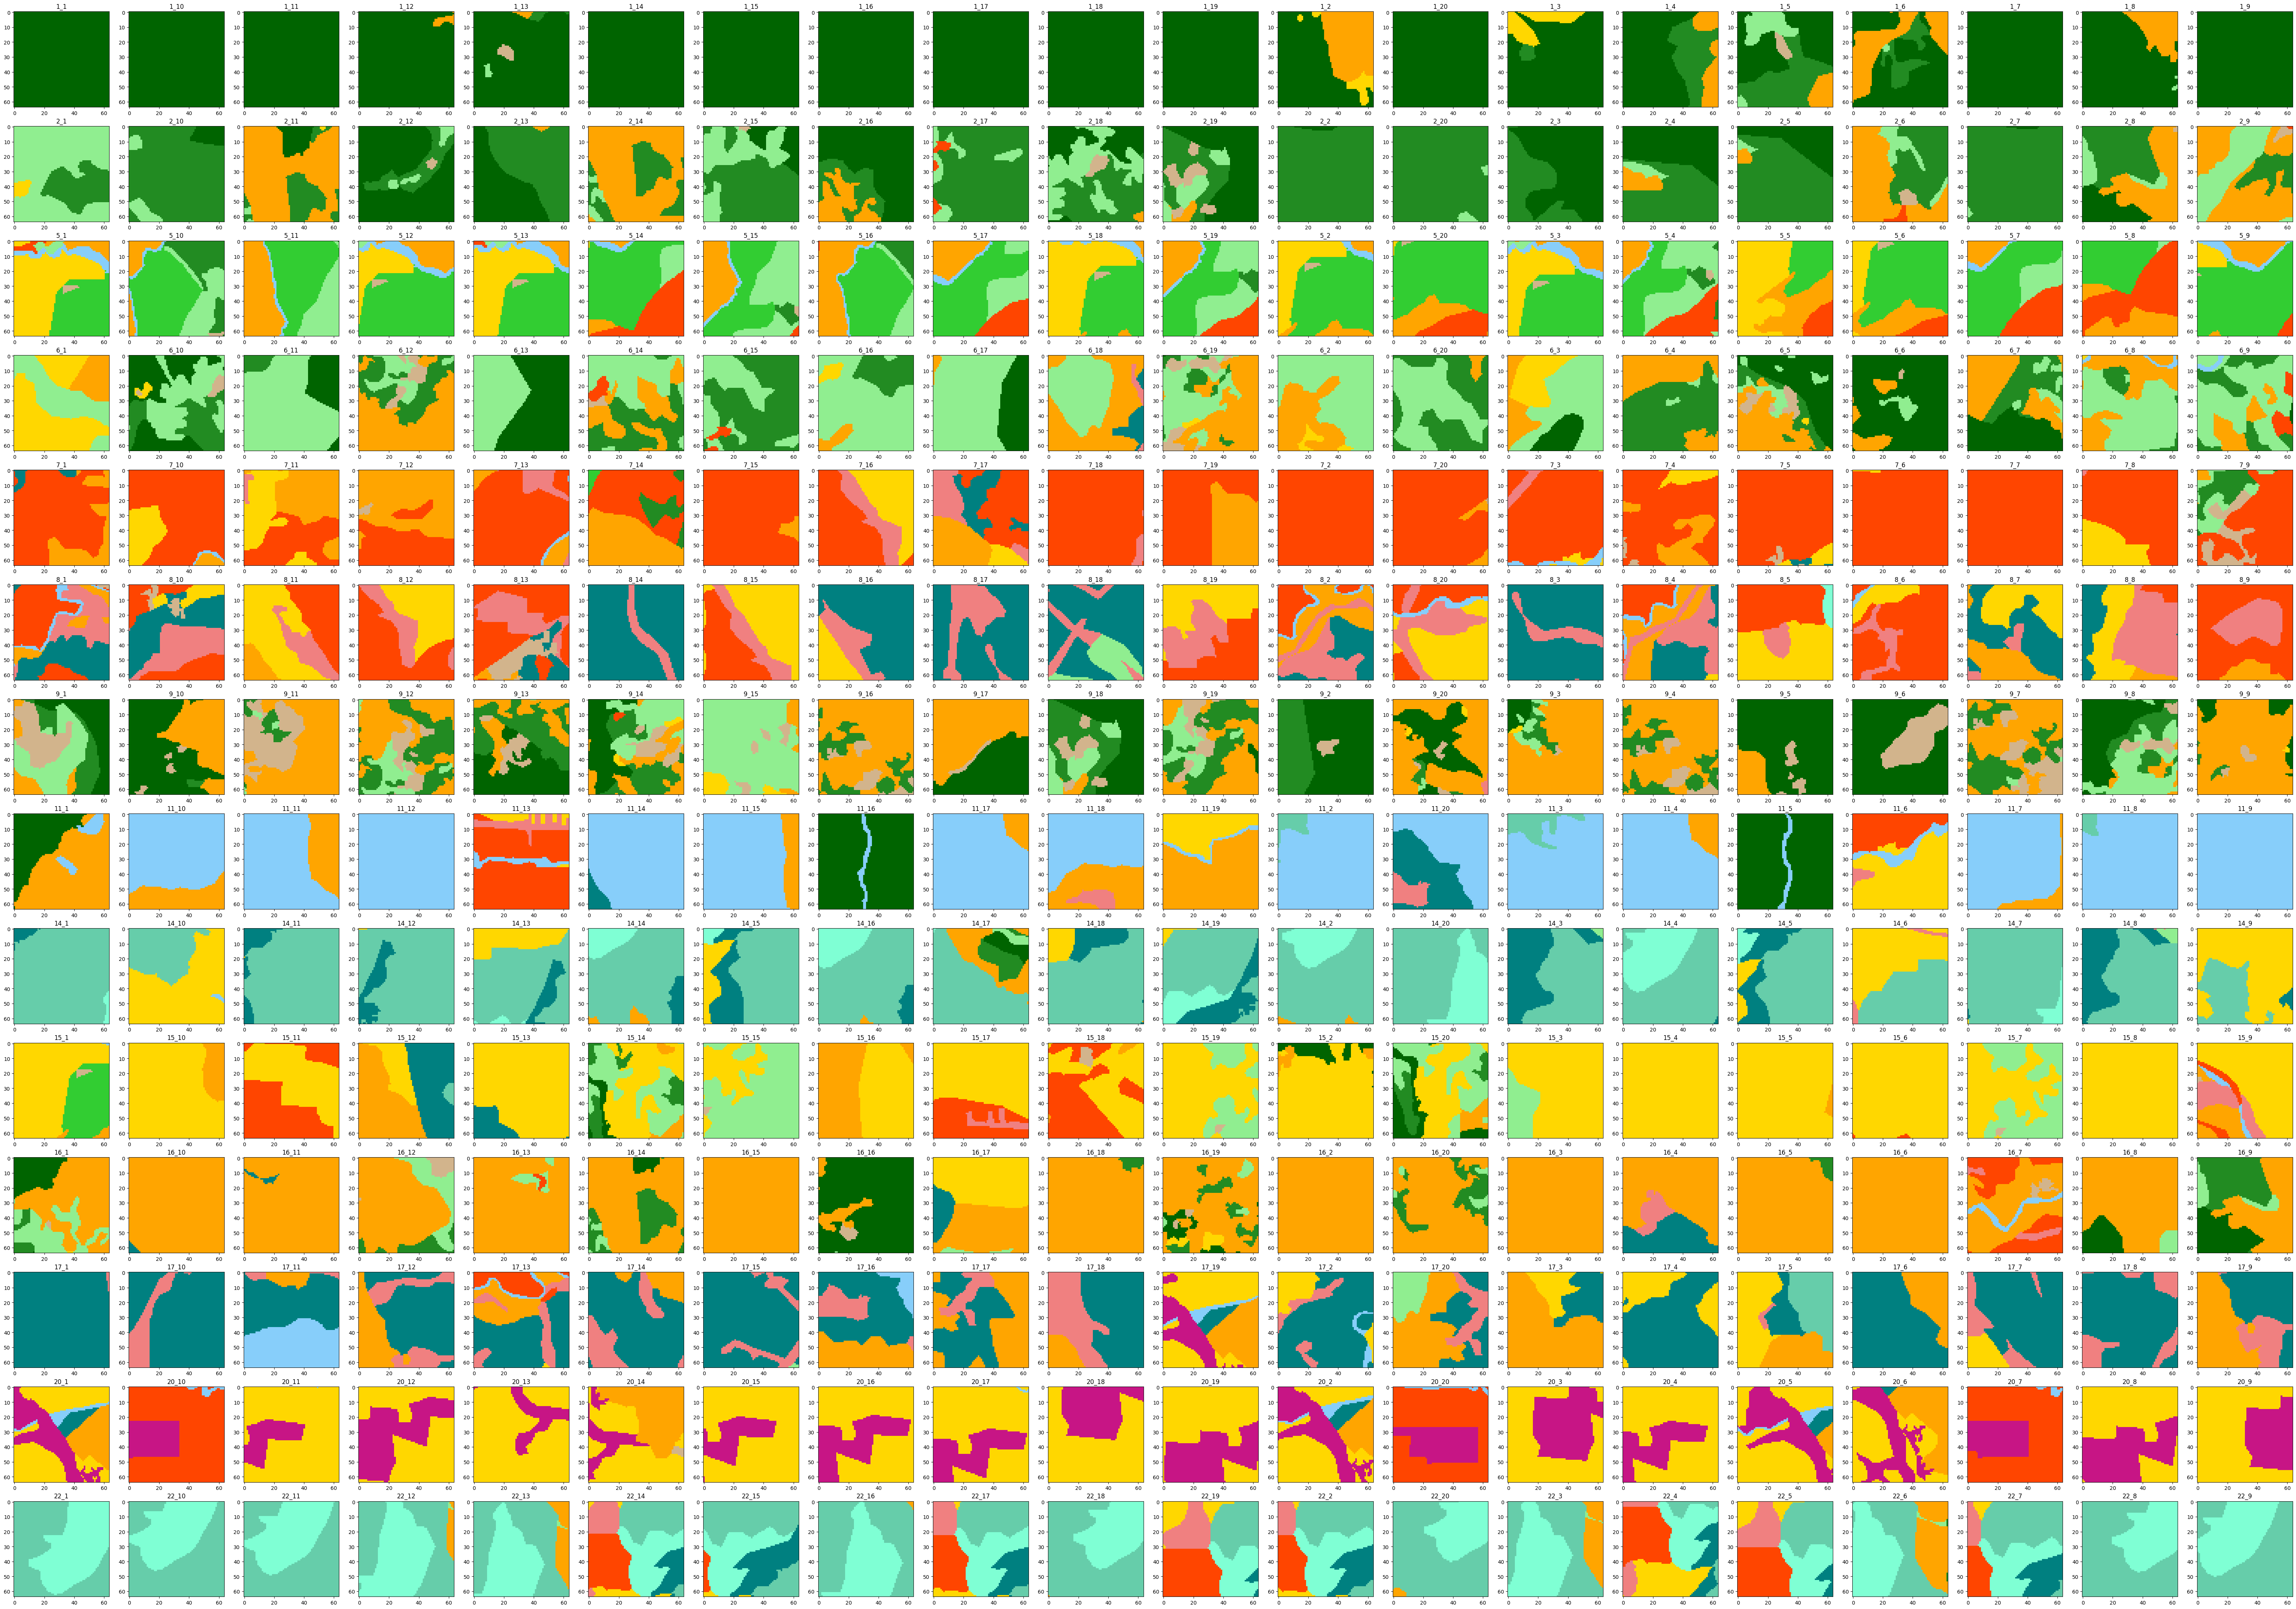

In [62]:
# Load lc first
plt.figure(figsize=(4 * image_per_lc, 4 * len(lc_values)))

lcs_train = []
lcs_test = []

for x in range(0, len(lc_values)):
	lc = lc_values[x]
	images_list = os.listdir('data/lcs')
	images_list = list(filter(lambda x: int(x.split('_')[0]) == lc, images_list))

	for y in range(0, len(images_list)):
		dir = images_list[y]
		name = dir.split('.')[0]
		image_dir = f'data/lcs/{dir}'
		source = rio.open(image_dir)
		image = source.read()

		# Transposed the image into an image object
		transposed = np.transpose(image, (1, 2, 0))

		# Augment then add to the list
		augment(transposed, lcs_train if (y < index_train) else lcs_test)

		# Plot the land cover
		plt.subplot(len(lc_values), image_per_lc, x * image_per_lc + y + 1)
		plt.imshow(image[0], cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
		plt.title(f'{name}')

		source.close()

lcs_train = np.stack(lcs_train)
lcs_test = np.stack(lcs_test)

In [63]:
print(f'Train_predictors_shape: {images_train.shape}\nTrain_label_shape: {lcs_train.shape}\nTest_predictors_shape: {images_test.shape}\nTest_label_shape: {lcs_test.shape}')

Train_predictors_shape: (1344, 64, 64, 3)
Train_label_shape: (1344, 64, 64, 1)
Test_predictors_shape: (336, 64, 64, 3)
Test_label_shape: (336, 64, 64, 1)


In [64]:
# Make lcs data into categorical
lcs_train_category = to_categorical(lcs_train)
lcs_test_category = to_categorical(lcs_test)

In [65]:
# Make keras model
input_shape = images_train.shape
input_shape = (input_shape[1], input_shape[2], input_shape[3])

neuron = 64
kernel = 3
kernel_t = 2
dropout = 0.1
strides = 2
pool = 2
padding = 'same'

input_layer = Input(input_shape)

def conv2_block(input, neuron, last=False):
	conv1 = Conv2D(neuron, kernel, activation='relu', padding=padding)(input)
	conv2 = Conv2D(neuron, kernel, activation='relu', padding=padding)(conv1)
	return conv2

def encode(input, neuron):
	conv1 = conv2_block(input, neuron)
	mp = MaxPooling2D(2)(conv1)
	dp = Dropout(dropout)(mp)
	return conv1, dp

def decode(input, conv, neuron):
	conv_t = Conv2DTranspose(neuron, kernel_t, strides, activation='relu', padding=padding)(input)
	concat = concatenate([conv_t, conv])
	conv2 = conv2_block(concat, neuron)
	dp = Dropout(dropout)(conv2)
	return dp

conv1, mp1 = encode(input_layer, neuron * 1)
conv2, mp2 = encode(mp1, neuron * 2)
conv3, mp3 = encode(mp2, neuron * 4)

transition = conv2_block(mp3, neuron * 8)

uncov1 = decode(transition, conv3, neuron * 4)
uncov2 = decode(uncov1, conv2, neuron * 2)
uncov3 = decode(uncov2, conv1, neuron * 1)

output = Conv2D(lcs_train_category.shape[3], 1, padding=padding, activation='softmax')(uncov3)

model = Model(input_layer, output)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 64, 64,    │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_63[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ conv2d_64[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 32, 32,    │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 32, 32,    │     73,856 │ dropout_24[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_65[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_66[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 16, 16,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │    295,168 │ dropout_25[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_67[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 8, 8, 256) │          0 │ conv2d_68[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 8, 8, 256) │          0 │ max_pooling2d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 16, 16,    │    524,544 │ conv2d_70[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,698,775 (29.37 MB)

 Trainable params: 7,698,775 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile and build the model
model.compile(
	optimizer=keras.optimizers.Adam(0.0001),
	loss=keras.losses.CategoricalCrossentropy(),
	metrics=[keras.metrics.CategoricalAccuracy()
])

callbacks = [
	EarlyStopping(patience=5, monitor='categorical_accuracy')
]

result = model.fit(
	x=images_train,
	y=lcs_train_category,
	epochs=100,
	batch_size=16,
	shuffle=True,
	validation_split=0.1,
	callbacks=callbacks
)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 559ms/step - categorical_accuracy: 0.1218 - loss: 3.0170 - val_categorical_accuracy: 0.1636 - val_loss: 2.9852
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - categorical_accuracy: 0.1711 - loss: 2.5197 - val_categorical_accuracy: 0.1055 - val_loss: 2.9845
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 588ms/step - categorical_accuracy: 0.3116 - loss: 2.1660 - val_categorical_accuracy: 0.1116 - val_loss: 3.0770
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 48s 628ms/step - categorical_accuracy: 0.3300 - loss: 1.9584 - val_categorical_accuracy: 0.1717 - val_loss: 2.8153
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 46s 605ms/step - categorical_accuracy: 0.3500 - loss: 1.8648 - val_categorical_accuracy: 0.1120 - val_loss: 2.6901
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 551ms/step - categorical_accuracy: 0.3498 - loss: 1.8652 - val_categorical_accuracy: 0.1750 - val_loss: 2.6485
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 599ms/step - categorical_accuracy

    categorical_accuracy      loss  val_categorical_accuracy  val_loss
0               0.196590  2.521180                  0.009042  3.557776
1               0.332718  1.980175                  0.027112  3.298338
2               0.360721  1.854204                  0.028942  2.925596
3               0.382213  1.761983                  0.118106  2.394995
4               0.393547  1.692943                  0.303103  2.307450
5               0.412159  1.630749                  0.280179  2.565812
6               0.438440  1.566003                  0.311003  2.670558
7               0.433277  1.560433                  0.406807  2.713943
8               0.455137  1.483412                  0.388180  2.592806
9               0.458517  1.472914                  0.429890  2.208458
10              0.457253  1.475916                  0.462956  2.300170
11              0.479938  1.426250                  0.394090  2.931449
12              0.476764  1.400865                  0.467267  2.634397
13    

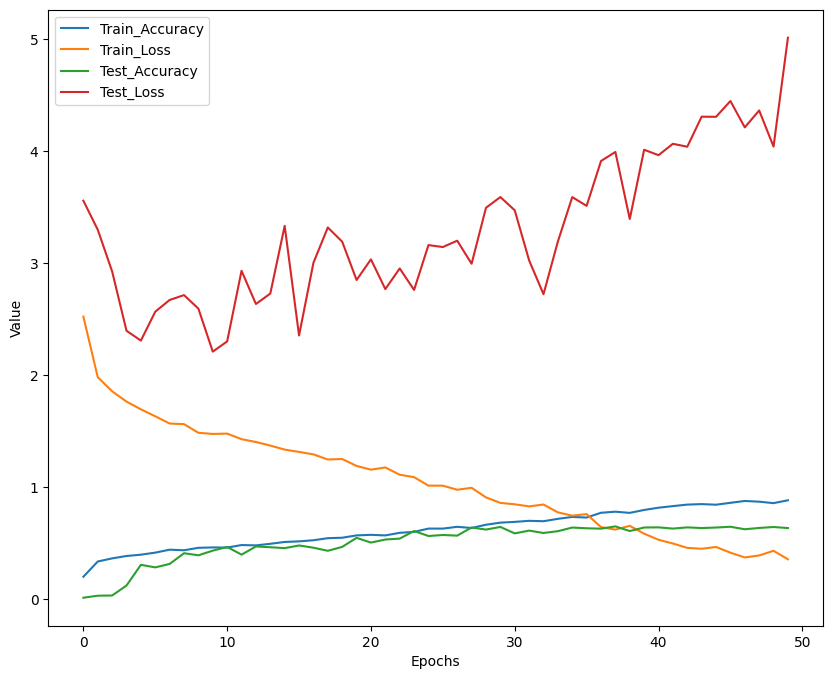

In [ ]:
# Show history
history = pd.DataFrame(result.history)
print(history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['categorical_accuracy'].values.tolist())), history['categorical_accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_categorical_accuracy'].values.tolist())), history['val_categorical_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Predict test data
prediction = np.argmax(model.predict(images_test), 3).flatten()
label = lcs_test.flatten()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


              precision    recall  f1-score   support

           1       0.88      0.76      0.82     34386
           2       0.43      0.67      0.52     16980
           5       0.62      0.65      0.63     16398
           6       0.43      0.21      0.28     19362
           7       0.49      0.61      0.55     34302
           8       0.43      0.41      0.42     11694
           9       0.07      0.01      0.02      6336
          11       0.95      0.98      0.97     24966
          14       0.86      0.48      0.62     23718
          15       0.37      0.40      0.38     47442
          16       0.46      0.55      0.50     50082
          17       0.59      0.66      0.63     30402
          20       0.74      0.70      0.72     12816
          22       0.90      0.57      0.70     15180

    accuracy                           0.58    344064
   macro avg       0.59      0.55      0.55    344064
weighted avg       0.59      0.58      0.57    344064



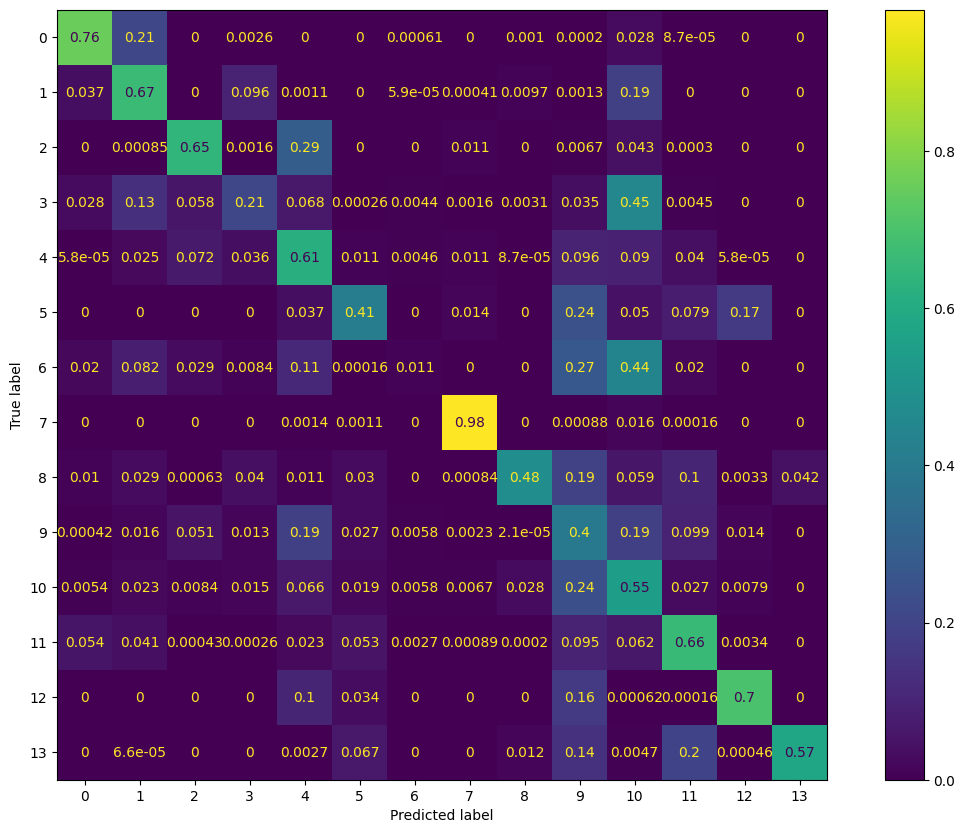

In [ ]:
# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
fig, ax = plt.subplots(figsize=(15, 10))
cm = ConfusionMatrixDisplay(cm)
cm.plot(ax = ax)

# Classification report
print(classification_report(label, prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

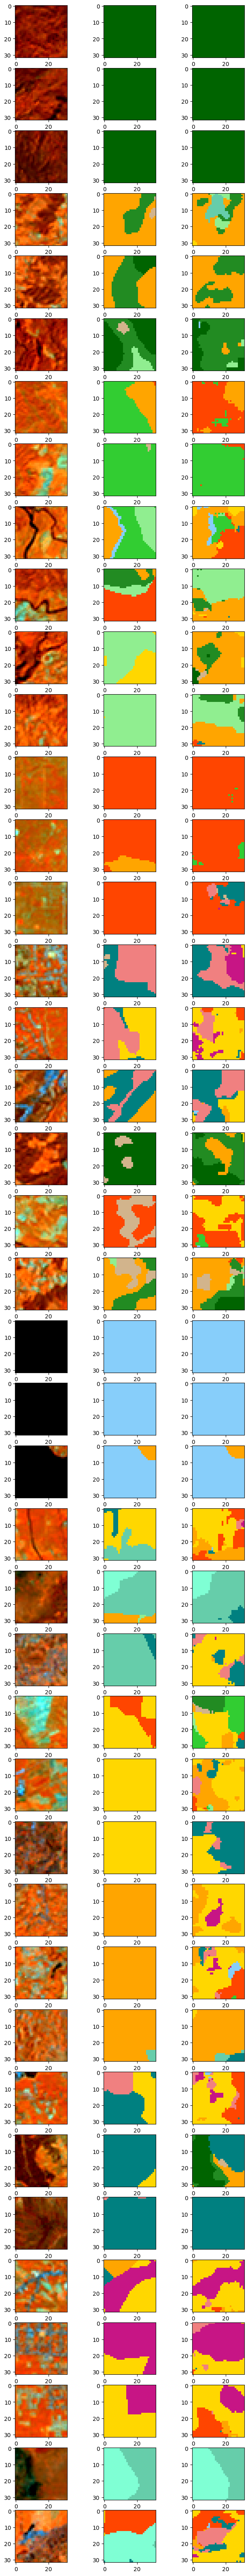

In [ ]:
image_non_augment_size = int(len(images_test) / 8)

plt.figure(figsize=(8, image_non_augment_size * 2))

# Apply to classified image of the image
for x in range(0, image_non_augment_size - 1):
	index = x * 8

	image = images_test[index:(index + 1)]
	pred = model.predict(image)
	pred = np.argmax(pred, 3)[0]

	plt.subplot(image_non_augment_size, 3, x * 3 + 1)
	plt.imshow(image[0])

	plt.subplot(image_non_augment_size, 3, x * 3 + 2)
	plt.imshow(lcs_test[index], cmap=cmap, interpolation='nearest', vmin=1, vmax=22)

	plt.subplot(image_non_augment_size, 3, x * 3 + 3)
	plt.imshow(pred, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)

In [ ]:
# Save model
model.save('data/dl_unet_landcover_model_v1.keras')